In [55]:
# Dependências necessárias para o projeto.

!pip install pymongo
!pip install python-dotenv
!pip install pymongo[srv]
!pip install dnspython


In [79]:
# Importações.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from dotenv import load_dotenv
from bson.binary import Binary
from bson import ObjectId
import pymongo, gridfs
from pymongo import MongoClient
from gridfs import GridFS


In [80]:
# Busca as variáveis de ambiente.

load_dotenv()

True

In [1]:
#baixa o dataset das imagens.

!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  10.7M      0  0:01:12  0:01:12 --:--:-- 10.6M


In [5]:
# extrai do arquivo baixadoas imagens.

!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [6]:
# Visualiza as pastas com as imagens.
!ls PetImages

Cat  Dog


In [7]:
# Deleta as imagens com problemas.

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [81]:
# Dimensiona o tamanho da imagem, define o treino e a validação gerando  um dataset.

image_size = (48, 48)
batch_size = 24

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1875 files belonging to 2 classes.
Using 1500 files for training.
Found 1875 files belonging to 2 classes.
Using 375 files for validation.


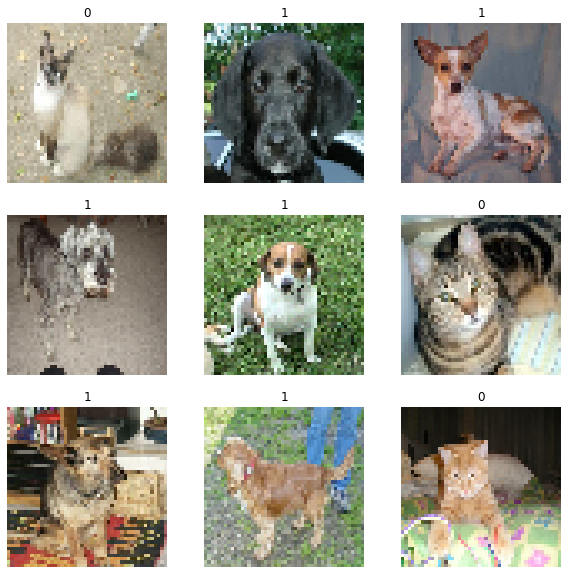

In [58]:
# Visualiza os dados, aqui estão as nove primeiras imagens do conjunto de dados do treinamento.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [59]:
# Aumento de dados de imagem.

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

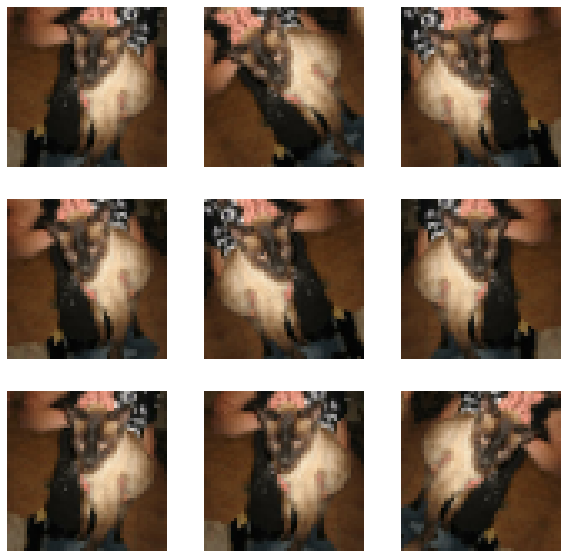

In [6]:
# Visualiza os dados, é uma boa prática introduzir artificialmente adversidade de amostras
# aplicando transformações aleatórias, como inversão horizontal e pequenas rotações .


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [60]:
# Aumento do dataset com as imagens transformadas.

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [61]:
# Configurando o conjunto de dados.

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [62]:
# Construção do modelo.

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Bloco de aumento de imagem
    x = data_augmentation(inputs)

    # Bloco de entrada
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Separa o resíduo

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Resíduo do projeto
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Adiciona de volta  resíduo
        previous_block_activation = x  # Separa o próximo resduo

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


In [63]:
# Executa o model.

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
# Treina o modelo.

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/10
781/781 [==============================] - 35s 41ms/step - loss: 0.6141 - accuracy: 0.6716 - val_loss: 0.5419 - val_accuracy: 0.7270
Epoch 2/10
781/781 [==============================] - 31s 40ms/step - loss: 0.5154 - accuracy: 0.7521 - val_loss: 0.5040 - val_accuracy: 0.7463
Epoch 3/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4700 - accuracy: 0.7798 - val_loss: 0.5164 - val_accuracy: 0.7542
Epoch 4/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4381 - accuracy: 0.7973 - val_loss: 1.1096 - val_accuracy: 0.5790
Epoch 5/10
781/781 [==============================] - 30s 38ms/step - loss: 0.4114 - accuracy: 0.8144 - val_loss: 0.4405 - val_accuracy: 0.7832
Epoch 6/10
781/781 [==============================] - 31s 39ms/step - loss: 0.3890 - accuracy: 0.8276 - val_loss: 0.4559 - val_accuracy: 0.7704
Epoch 7/10
781/781 [==============================] - 30s 38ms/step - loss: 0.3713 - accuracy: 0.8358 - val_loss: 0.3571 - val_accuracy:

In [65]:
# Inferência com imagens salvas no projeto e modelo treinado

img = keras.preprocessing.image.load_img(
    "PetImages/Cat/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 1s 1s/step
This image is 49.99 percent cat and 50.01 percent dog.


In [88]:
#Salva o modelo no formato h5.

model.save('model.h5') 

In [82]:
# Define variáveis de ambiente.

db = os.getenv('DB')
client = os.getenv('CLIENT_PRODUCT') #CLIENT_DEVELOP or CLIENT_PRODUCT
collection = os.getenv('COLLECTION')
model_name = os.getenv('MODEL_NAME_B')

In [98]:
# Função para salvar o modelo no mongo.

def save_model_to_mongo( filename, client, db):
    try:
        cluster = pymongo.MongoClient(client)
        db = cluster["compass"]

        file_data = open(filename, 'rb')
        data = file_data.read()

        fs = gridfs.GridFS(db)
        fs.put(data, filename=filename)

        return 'success'
    except:
        return 'erro ao salvar o modelo no mongo.'
    



In [112]:
# Executa função para salvar no mongo.

save_model_to_mongo(client=client,db=db,filename='model.h5')

'success'

In [108]:
# Função para buscar o modelo no mongo.

def load_saved_model_from_mongo(filename, client, db):
    try:
        cluster = pymongo.MongoClient(client)
        db = cluster["compass"]
        fs = gridfs.GridFS(db)
        resp = db.fs.files.find_one({'filename':filename})
        model_atlas = fs.get(resp['_id']).read()
        output = open('model-from-mongo.h5','wb')
        output.write(model_atlas)
        output.close()
        return 'success'
    except:
        return 'erro ao buscar o modelo do mongo.'

In [109]:
# Executa função para buscar o modelo no mongo.

load_saved_model_from_mongo(filename='model.h5', client=client, db=db)

In [110]:
# Cria modelo com os dados salvos no mongo.

new_model = tf.keras.models.load_model('model-from-mongo.h5')

In [111]:
# Inferência com imagens salvas no projeto e modelo salvo no mongo.

img = keras.preprocessing.image.load_img(
    "PetImages/Dog/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 366ms/step
This image is 25.24 percent cat and 74.76 percent dog.
